In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
# reading in data and dropping useless columns
ratings = pd.read_csv('data/ratings.csv')

ratings.drop(columns='timestamp', axis=1, inplace=True)

In [3]:
# displaying dataframe
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [4]:
# reading in movies_metadata.csv
movies = pd.read_csv('data/movies_metadata.csv')

# renaming id column to movieId to match other df
movies.rename(columns=({'id':'movieId'}), inplace=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
import json

# deconstructing list of dictionaries to get only the values (genres)
movies['genres'] = movies['genres'].str.replace("'", '"').apply(lambda x: ','.join([_["name"] for _ in json.loads(x)]))

In [6]:
# only taking the genres, movieId, and title columns
movies = movies[['genres', 'movieId', 'title']]
movies.genres = movies.genres.str.split(',')

In [7]:
genres = pd.DataFrame(movies['genres'].tolist(), index=movies.index)
genres['movieId'] = movies['movieId']
genres['title'] = movies['title']

genres.fillna("", inplace=True)

In [8]:
genres.rename(columns={
    0:'genre_1',
    1:'genre_2',
    2:'genre_3',
    3:'genre_4',
    4:'genre_5',
    5:'genre_6',
    6:'genre_7',
    7:'genre_8'
}, inplace=True)

In [9]:
genres = genres[['movieId', 'title', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']]

genres.head()

,movieId,title,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8
0,862,Toy Story,Animation,Comedy,Family,,,,,
1,8844,Jumanji,Adventure,Fantasy,Family,,,,,
2,15602,Grumpier Old Men,Romance,Comedy,,,,,,
3,31357,Waiting to Exhale,Comedy,Drama,Romance,,,,,
4,11862,Father of the Bride Part II,Comedy,,,,,,,


In [10]:
joined = ratings.join(genres[['title','genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']], on='movieId')

In [11]:
joined.dropna(inplace=True)

In [12]:
joined.size

265061292

In [13]:
# getting number of ratings per movie
rating_count = joined.groupby('movieId').count()

# geting the average rating for each movie
avg_ratings = joined.groupby('movieId').mean()['rating']

# making sure the df has only movies with greater than 30 ratings
avg_ratings = avg_ratings.loc[rating_count['rating'] > 30]

# sorting df by descending order
sorted = avg_ratings.sort_values(ascending=False)

# putting sorted into df
sort_df = pd.DataFrame(sorted)

# resetting index
sort_df = sort_df.reset_index(level=0)

# renaming and adding the avg rating column to df
sort_df['avg_rating'] = sort_df['rating']

# dropping rating column
sort_df.drop(columns='rating', inplace=True)

# display df
sort_df.head()

,movieId,avg_rating
0,318,4.429015
1,858,4.339811
2,50,4.300189
3,527,4.266531
4,1221,4.263475


In [14]:
# number of ratings a user has given
joined['num_ratings']=joined.groupby('userId')['rating'].count()

# average rating of a title
joined['average_rating']=joined.groupby('userId')['rating'].mean()

joined.head()

,userId,movieId,rating,title,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,num_ratings,average_rating
0,1,110,1.0,Rumble in the Bronx,Crime,Action,Comedy,Thriller,,,,,NaN,NaN
1,1,147,4.5,Apollo 13,Drama,,,,,,,,13.0,4.307692
2,1,858,5.0,Bogus,Fantasy,Comedy,Family,,,,,,22.0,3.318182
3,1,1221,5.0,Unforgiven,Western,,,,,,,,10.0,3.100000
4,1,1246,5.0,Indiana Jones and the Last Crusade,Adventure,Action,,,,,,,62.0,3.500000


In [15]:
pop_movies = joined[joined['num_ratings'] > 100]

pop_movies

,userId,movieId,rating,title,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,num_ratings,average_rating
8,1,2959,4.0,Irma la Douce,Comedy,Romance,,,,,,,113.0,2.991150
12,1,33794,4.0,Life Without Principle,Action,Thriller,Crime,,,,,,248.0,3.854839
30,2,58,3.0,The Confessional,Thriller,Drama,Mystery,,,,,,120.0,3.950000
34,2,260,4.0,L'Enfer,Crime,Drama,,,,,,,209.0,3.758373
37,2,605,4.0,Jane Eyre,Drama,Romance,,,,,,,179.0,3.310056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270795,2847,30707,2.5,The Nickel Ride,Crime,,,,,,,,179.0,4.259777
270807,2847,33646,3.0,Baskin,Fantasy,Horror,,,,,,,251.0,3.549801
270828,2847,41569,3.5,Bleed for This,Drama,,,,,,,,480.0,3.400000
270833,2847,44199,4.0,The Velvet Underground and Nico,Music,Documentary,,,,,,,125.0,3.772000


In [28]:
# average rating for each movie df

final = joined.drop(['genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8'], axis=1).fillna(0)

In [29]:
final['userId'].drop_duplicates(inplace=True)

In [30]:
final['average_rating'] = final['average_rating'].astype('float64')
final['num_ratings'] = final['num_ratings'].astype('int64')

In [31]:
moviemelt = pop_movies.reset_index().pivot_table(values='rating', index='userId', columns='title').fillna(0)

melt = final.reset_index().pivot_table(values='average_rating', index='userId', columns='genre_1')

melt.fillna(0, inplace=True)

In [32]:
melt

genre_1,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,3.854839,3.884615,0.000000,3.305963,1.925595,0.000000,4.269231,0.000000,3.318182,...,0.000000,3.750000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,3.10000
2,1.500000,3.725601,0.000000,0.000000,4.103867,3.484604,0.000000,3.595669,3.910256,3.000000,...,0.000000,0.000000,0.0,0.0,3.633929,0.0,0.0,3.950000,0.000000,0.00000
3,0.000000,0.000000,4.032434,0.000000,4.105827,5.000000,0.000000,4.142857,0.000000,3.733333,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000
4,3.407563,3.465233,2.852568,3.514014,3.721668,3.731050,3.119718,3.715835,0.000000,3.285714,...,0.000000,3.723863,0.0,0.0,3.622222,0.0,0.0,3.257143,3.368434,3.79606
5,3.272727,3.852100,3.508849,0.000000,3.534461,0.000000,0.000000,3.955079,0.000000,4.659091,...,4.141414,3.333333,0.0,0.0,0.000000,0.0,0.0,3.250000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000
270893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000
270894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000


In [33]:
X = melt.drop('Action', axis=1)
y = melt['Action']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

In [35]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled

array([[-0.07437161, -0.08678542, -0.07371296, ..., -0.07474568,
        -0.05178579, -0.05230789],
       [11.94715631, 11.08405241, -0.07371296, ..., 11.87362158,
        -0.05178579, -0.05230789],
       [-0.07437161, -0.08678542, -0.07371296, ..., -0.07474568,
        -0.05178579, -0.05230789],
       ...,
       [-0.07437161, -0.08678542, -0.07371296, ..., -0.07474568,
        -0.05178579, -0.05230789],
       [-0.07437161, -0.08678542, -0.07371296, ..., -0.07474568,
        -0.05178579, -0.05230789],
       [-0.07437161, -0.08678542, -0.07371296, ..., -0.07474568,
        -0.05178579, -0.05230789]])

In [36]:
# MODEL TO PREDICT THE SCORE OF A MOVIE IN A CERTAIN GENRE (COMEDY)

num_input = 20
hl1 = 100
hl2 = 50
hl3 = 25

nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=hl1, input_dim = num_input, activation='relu'))

nn.add(tf.keras.layers.Dense(units=hl2, activation='relu'))

nn.add(tf.keras.layers.Dense(units=hl3, activation='relu'))

nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "mse"])

In [39]:
fit_model = nn.fit(X_train_scaled, y_train,epochs=10)

Epoch 1/10
6318/6318 [==============================] - 18s 3ms/step - loss: -3126447616.0000 - accuracy: 0.9894 - mse: 0.0618
Epoch 2/10
6318/6318 [==============================] - 19s 3ms/step - loss: -6497666048.0000 - accuracy: 0.9894 - mse: 0.0618
Epoch 3/10
6318/6318 [==============================] - 17s 3ms/step - loss: -11925026816.0000 - accuracy: 0.9894 - mse: 0.0619
Epoch 4/10
6318/6318 [==============================] - 18s 3ms/step - loss: -20008800256.0000 - accuracy: 0.9894 - mse: 0.0618
Epoch 5/10
6318/6318 [==============================] - 20s 3ms/step - loss: -31698460672.0000 - accuracy: 0.9894 - mse: 0.0619
Epoch 6/10
6318/6318 [==============================] - 19s 3ms/step - loss: -48060628992.0000 - accuracy: 0.9894 - mse: 0.0619
Epoch 7/10
6318/6318 [==============================] - 20s 3ms/step - loss: -69438128128.0000 - accuracy: 0.9896 - mse: 0.0617
Epoch 8/10
6318/6318 [==============================] - 19s 3ms/step - loss: -96994041856.0000 - accuracy:

<AxesSubplot:>

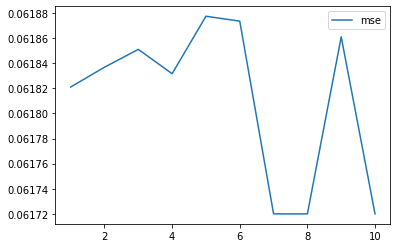

In [40]:
pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1)).plot(y="mse")

In [41]:
model_loss, model_accuracy, mean_squared_error = nn.evaluate(X_test_scaled,y_test,verbose=2)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, MSE: {mean_squared_error}")

2106/2106 - 4s - loss: -2.0405e+11 - accuracy: 0.9892 - mse: 0.0634 - 4s/epoch - 2ms/step
Loss: -204052430848.0, Accuracy: 0.9892405867576599, MSE: 0.06341465562582016


In [42]:
# MODEL TO PREDICT THE AVERAGE RATING OF A SPECIFIC MOVIE (The Lion King)

b = moviemelt.drop('Legend', axis=1)
g = moviemelt['Legend']

b_train, b_test, g_train, g_test = train_test_split(b, g, random_state=15)

b_train_scaled = scaler.fit_transform(b_train)
b_test_scaled = scaler.fit_transform(b_test)



num_input = 4907
hl1 = 200
hl2 = 100
hl3 = 50

mov = tf.keras.models.Sequential()

mov.add(tf.keras.layers.Dense(units=hl1, input_dim = num_input, activation='relu'))

mov.add(tf.keras.layers.Dense(units=hl2, activation='relu'))

mov.add(tf.keras.layers.Dense(units=hl3, activation='relu'))

mov.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

mov.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               981600    
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,006,801
Trainable params: 1,006,801
Non-trainable params: 0
_________________________________________________________________


In [43]:
mov.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "mse"])

In [44]:
model = mov.fit(b_train_scaled, g_train,epochs=100)

Epoch 1/100
62/62 [==============================] - 2s 16ms/step - loss: 0.1501 - accuracy: 0.9740 - mse: 0.0349
Epoch 2/100
62/62 [==============================] - 1s 16ms/step - loss: 0.0177 - accuracy: 0.9990 - mse: 0.0160
Epoch 3/100
62/62 [==============================] - 1s 16ms/step - loss: 0.0069 - accuracy: 0.9990 - mse: 0.0147
Epoch 4/100
62/62 [==============================] - 1s 16ms/step - loss: -0.0045 - accuracy: 0.9990 - mse: 0.0112
Epoch 5/100
62/62 [==============================] - 1s 20ms/step - loss: -0.0152 - accuracy: 0.9990 - mse: 0.0107
Epoch 6/100
62/62 [==============================] - 1s 23ms/step - loss: -0.0373 - accuracy: 0.9990 - mse: 0.0097
Epoch 7/100
62/62 [==============================] - 1s 20ms/step - loss: -0.0971 - accuracy: 0.9990 - mse: 0.0092
Epoch 8/100
62/62 [==============================] - 1s 15ms/step - loss: -0.2297 - accuracy: 0.9985 - mse: 0.0096
Epoch 9/100
62/62 [==============================] - 1s 16ms/step - loss: -0.4439 -

In [45]:
loss, accuracy, mse = mov.evaluate(b_test_scaled,g_test,verbose=2)

print(f"Loss: {loss}, Accuracy: {accuracy}, MSE: {mse}")

21/21 - 0s - loss: 8722.7832 - accuracy: 0.9740 - mse: 0.0382 - 295ms/epoch - 14ms/step
Loss: 8722.783203125, Accuracy: 0.9740061163902283, MSE: 0.03822629898786545


In [ ]:
# from google.colab import files
# moviemelt.to_csv('moviemelt.csv', encoding = 'utf-8-sig') 
# files.download('moviemelt.csv')